In [ ]:
# Install/Update mplfinance if not installed
# !pip install --upgrade mplfinance

# **Source Code**

In [5]:
import inspect
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import datetime as dt
from io import BytesIO
import mplfinance as mpf
from pathlib import Path
from scipy.stats import norm
import matplotlib.pyplot as plt
from typing import Optional

def calculate_z_score(confidence_level):
    # Calculate the Z-score corresponding to the given one-tailed confidence level
    z_score = norm.ppf(confidence_level)
    return z_score


class pyFinance:

  def __init__(self, timeout: int = 20):
    """
        Initialize pyFinance class.

        Args:
        - timeout (int, optional): Timeout value for HTTP requests. Defaults to 20.
    """
    self.base_url = 'https://www.nseindia.com'

    # Common header values that browsers typically send so that server does not consider our requests as sent by bot
    self.headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'accept-language': 'en-US,en;q=0.9'
    }
    self.timeout = timeout
    self.cookies = []


  def __getCookies(self, renew: bool = False) -> dict:
    """
        Get cookies for maintaining session.

        Args:
        - renew (bool, optional): Flag to renew cookies. Defaults to False.

        Returns:
        - dict: Dictionary of cookies.
    """
    if len(self.cookies) > 0 and renew == False:
      return self.cookies

    r = requests.get(self.base_url, timeout=self.timeout, headers=self.headers)
    self.cookies = dict(r.cookies)
    return self.__getCookies()


  def help(self, function: Optional[str] = None) -> None:
    if function is None:
      print("""
        pyFinance is a class that provides access to financial data and tools.
      """)

      print("\tAvailable functions:")
      for name, function in inspect.getmembers(self, predicate=inspect.ismethod):
        print(f"\t* {name}")

      print("""
        For more information on a specific method, please call the method with the help argument. For example:

            pyFinance.function_name.__doc__


        For more help you can call help function:

            pyFinance.help("get_historical_data")
        """)

    else:
      fn = getattr(self, function, None)
      if fn is None:
        print(f"Function '{function}' not found.")
      else:
        print(fn.__doc__)


  def get_historical_data(self, ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    """
        Fetch historical data for a given ticker and date range.

        Args:
        - ticker (str): Stock symbol.
        - start_date (str): Start date for historical data.
        - end_date (str): End date for historical data.

        Returns:
        - pandas.DataFrame: DataFrame containing historical data.
    """
    try:
        df = yf.download(ticker, start=start_date, end=end_date)
    except Exception as e:
        print(f"Error fetching historical data: {e}")
        df = pd.DataFrame()  # Empty DataFrame in case of error
    return df



  def get_historical_data_from_NSE(self, symbol: str, series: str, start_date: dt.date, end_date: dt.date) -> pd.DataFrame:
    """
        Get historical data from NSE for a given symbol and date range.

        Args:
        - symbol (str): Stock symbol.
        - series (str): Series type.
        - start_date (datetime.date): Start date for historical data.
        - end_date (datetime.date): End date for historical data.

        Returns:
        - pandas.DataFrame: DataFrame containing historical data.
    """
    try:
      url = "/api/historical/cm/equity?symbol={0}&series=[%22{1}%22]&from={2}&to={3}&csv=true".format(symbol.replace('&','%26'), series, start_date.strftime('%d-%m-%Y'), end_date.strftime('%d-%m-%Y'))
      res = requests.get(self.base_url + url, headers=self.headers, timeout= self.timeout, cookies=self.__getCookies())

      if res.status_code != 200:
        res = requests.get(self.base_url + url, headers=self.headers, timeout= self.timeout, cookies=self.__getCookies(True))

      res.raise_for_status()

      df = pd.read_csv(BytesIO(res.content), sep = ',', thousands=',')
      return df
    except requests.exceptions.HTTPError as http_err:
      print(f"HTTP error occurred: {http_err}")
    except requests.exceptions.Timeout as timeout_err:
      print(f"Timeout error occurred: {timeout_err}")
    except requests.exceptions.RequestException as req_err:
      print(f"Request error occurred: {req_err}")
    except Exception as e:
      print(f"Error Fetching Historical Data from NSE: {e}")



  def download_dataframe_as_file(self, df: pd.DataFrame, file_format: str, file_name: str) -> None:
    """
      Download a DataFrame as a file in the specified format.

      Args:
      - df: The DataFrame to be downloaded.
      - file_format: The format of the file to be downloaded ('pdf', 'csv', 'excel', 'json', 'html', 'feather').
      - file_name: The name of the file to be downloaded (without extension).
    """
    try:
      if file_format == 'pdf':
          # Create a PDF file
          pdf_buffer = BytesIO()
          fig, ax = plt.subplots(figsize=(15, 6))
          ax.axis('tight')
          ax.axis('off')
          ax.table(cellText=df.values, colLabels=df.columns, bbox=[0, 0, 1, 1])
          plt.savefig(pdf_buffer, format='pdf')
          pdf_buffer.seek(0)
          Path(f'{file_name}.pdf').write_bytes(pdf_buffer.read())
          plt.close()

      elif file_format == 'csv':
          # Create a CSV file
          df.to_csv(f'{file_name}.csv', index=False)

      elif file_format == 'excel':
          # Create an Excel file
          df.to_excel(f'{file_name}.xlsx', index=False)

      elif file_format == 'json':
          # Create a JSON file
          df.to_json(f'{file_name}.json', orient='records')

      elif file_format == 'html':
          # Create an HTML file
          df.to_html(f'{file_name}.html', index=False)

      elif file_format == 'feather':
          # Create a Feather file
          df.to_feather(f'{file_name}.feather')
      else:
          raise ValueError("Invalid file format. Please use 'pdf', 'csv', 'excel', 'json', 'html', or 'feather'.")
    except Exception as e:
            print(f"Error downloading DataFrame as file: {e}")




  def visualize_historical_data(self, ticker: str, start_date: str, end_date: str, title=None, ylabel=None):
        """
        Create two separate line plots and one candle chart to visualize historical data and
        market capitalization for a given ticker and time period.

        Parameters:
        - ticker: Ticker symbol for the stock.
        - start_date: Start date for historical data (YYYY-MM-DD).
        - end_date: End date for historical data (YYYY-MM-DD).
        - title: Title for the plots (optional).
        - ylabel: Label for the y-axis (optional).
        """
        try:
            df = self.get_historical_data(ticker, start_date, end_date)

            if df.empty or 'Adj Close' not in df.columns:
                raise ValueError("Invalid DataFrame or missing 'Adj Close' column")

            # Calculate market capitalization
            df['Market Cap'] = df['Close'] * df['Volume']  # Assuming Volume represents number of shares

            sns.set_style("whitegrid")
            plt.figure(figsize=(10, 5))

            # Plotting historical stock price
            plt.subplot(1, 2, 1)
            plt.plot(df.index, df['Adj Close'], label='Adjusted Close', color='b')
            plt.fill_between(df.index, df['Adj Close'], color='skyblue', alpha=0.3)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel(ylabel if ylabel else 'Price', fontsize=12)
            plt.title('Historical Stock Prices', fontsize=14)
            plt.legend(fontsize=10)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)

            # Plotting market capitalization
            plt.subplot(1, 2, 2)
            plt.plot(df.index, df['Market Cap'], label='Market Cap', color='g', linestyle='--')
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Market Cap', fontsize=12)
            plt.title('Market Capitalization', fontsize=14)
            plt.legend(fontsize=10)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)

            plt.tight_layout()
            plt.suptitle(title if title else 'Historical Data and Market Cap', fontsize=16)
            plt.show()
            print("")

            mpf.plot(df, type='candle', ylabel='Price', ylabel_lower='Volume',
                     title=f'{ticker} Candlestock Chart',
                     figratio=(10, 6), figscale=1.0, mav=(20, 50), volume_panel=1,
                     volume=True, tight_layout=True, style='yahoo')

        except Exception as e:
            print(f"Error visualizing historical data: {e}")



  def calculate_valuation_ratios(self, ticker: str):
      """
      Fetch fundamental data for a given ticker from Yahoo Finance, calculate valuation ratios,
      and return the results as a dictionary.

      Parameters:
      - ticker: Ticker symbol of the stock (e.g., 'AAPL' for Apple).
      """
      try:
          ticker_obj = yf.Ticker(ticker)
          fundamental_data = ticker_obj.info

          ratios = {}
          if 'trailingPE' in fundamental_data and 'bookValue' in fundamental_data and 'previousClose' in fundamental_data:
              ratios['P/E Ratio'] = fundamental_data['trailingPE']
              ratios['P/B Ratio'] = fundamental_data['bookValue'] / fundamental_data['previousClose']

              if 'revenue' in fundamental_data and 'sharesOutstanding' in fundamental_data:
                  ratios['P/S Ratio'] = fundamental_data['revenue'] / fundamental_data['sharesOutstanding']

              if 'earningsGrowth' in fundamental_data:
                  earnings_growth_rate = fundamental_data['earningsGrowth'] * 100  # Assuming annual growth rate
                  ratios['PEG Ratio'] = ratios['P/E Ratio'] / earnings_growth_rate

          if ratios:
              return ratios
          else:
              return None
      except Exception as e:
          print(f"Error calculating valuation ratios for {ticker}: {str(e)}")
          return None



  def calculate_moving_average(self, data: pd.DataFrame, period: int = 5, visualize: bool = True):
        """
        Calculates and optionally plots the moving average of the 'Close' prices from a given DataFrame.

        Args:
            data (pandas.DataFrame): A DataFrame containing at least a 'Close' column with closing prices.
            period (int): The number of periods over which to calculate the moving average. Default is 5.
            visualize (bool): If True, the function will plot the moving average along with the closing prices. Default is True.

        Returns:
            pandas.DataFrame: The DataFrame with an additional column for the moving average.

        Raises:
            KeyError: If the input DataFrame does not contain the 'Close' column.
            ValueError: If the period is less than 1.
            Exception: For any unexpected errors during the calculation or plotting.
        """
        try:
            moving_average = data['Close'].rolling(window=period).mean()

            if visualize:
                plt.figure(figsize=(10, 6))
                plt.plot(data.index, data['Close'], label='Close Price', color='blue')
                plt.plot(data.index, moving_average , label=f'Moving Average ({period}-day)', color='orange')
                plt.title("Moving Average Plot")
                plt.xlabel('Date')
                plt.ylabel('Price')
                plt.legend()
                plt.grid(True)
                plt.show()

            return moving_average

        except KeyError as e:
            print(f"KeyError: {e}")
        except ValueError as e:
            print(f"ValueError: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            return None



  def calculate_moving_average_convergence_divergence(self, df: pd.DataFrame, short_window:int=12, long_window:int=26, visualize:bool=True):
    """
      Calculate the Moving Average Convergence Divergence (MACD) for a given DataFrame.

      Args:
      - df: DataFrame containing historical stock price data with 'Close' prices.
      - short_window: The short moving average window for MACD calculation (default is 12).
      - long_window: The long moving average window for MACD calculation (default is 26).
      - visualize (bool): If True, the function will plot the results along with the closing price (default is True).

      Returns:
      - df: DataFrame containing historical stock price data with MACD values.
    """
    try:
      if 'Close' not in df.columns:
        raise ValueError("DataFrame must contain 'Close' column for price data.")

      if short_window <= 0 or long_window <= 0:
        raise ValueError("Window lengths must be positive integers.")

      df[f'{short_window}_ema'] = df['Close'].ewm(span=short_window, adjust=False).mean()
      df[f'{long_window}_ema'] = df['Close'].ewm(span=long_window, adjust=False).mean()
      df['MACD'] = df[f'{short_window}_ema'] - df[f'{long_window}_ema']
      df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

      if visualize:
        plt.figure(figsize=(10, 5))
        plt.plot(df.index, df['Close'], label='Close Price', color='black')
        plt.plot(df.index, df['MACD'], label='MACD', color='blue')
        plt.plot(df.index, df['Signal_Line'], label='Signal Line', color='red')
        plt.legend()
        plt.title('MACD and Signal Line')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.show()

    except ValueError as e:
      print(f"Error in calculating MACD: {e}")
    except Exception as e:
      print(f"An unexpected error occurred: {e}")
    return df



  def calculate_volatility(self, data: pd.DataFrame, period:int=20, title:str="Volatility Plot"):
        """
        Calculates the rolling standard deviation of daily returns of a stock (volatility) and plots it.

        Args:
            data (pandas.DataFrame): A DataFrame containing 'Close' prices of the stock.
            window (int): The number of periods over which to calculate the rolling standard deviation. Default is 20.
            title (str): Title of the plot. Default is "Volatility Plot".

        Returns:
            pandas.Series: A Series representing the volatility (rolling standard deviation) of the stock's returns.

        Raises:
            KeyError: If the 'Close' column is missing in the data.
            Exception: For any unexpected errors during calculation or plotting.
        """
        try:

            # Daily returns
            daily_returns = data['Close'].pct_change()
            # Calculate the rolling standard deviation
            volatility = daily_returns.rolling(window=period).std()

            plt.figure(figsize=(10, 6))
            plt.plot(data.index, volatility, label='Rolling Std Dev (Volatility)', color='purple')
            plt.title(title)
            plt.xlabel('Date')
            plt.ylabel('Volatility')
            plt.legend()
            plt.grid(True)
            plt.show()

            return volatility
        except KeyError as e:
            print(f"KeyError: {e}")
            return None
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            return None




  def calculate_relative_strength_index(self, df: pd.DataFrame, period:int=14, visualize:bool=True):
        """
        Calculates the Relative Strength Index (RSI) of a given time series data for a given period and time frame.

        Args:
            - df: DataFrame containing historical stock price data with 'Close' prices.
            - period (int): RSI period in days (default = 14)
            - visualize (bool): flag to plot a graph

        Returns:
            pandas.Series: Relative Strength Index (RSI) of the time series data.

        Function Call:
            calculate_relative_strength_index(data, period, visualize)
        """

        try:
            if not isinstance(period, int) or not period >= 1:
                raise ValueError("Period must be an integer with value >=1")
            if df.empty or 'Adj Close' not in df.columns:
                raise ValueError("Invalid DataFrame or missing 'Adj Close' column")

            # Calculate daily returns
            df['Returns'] = df['Adj Close'].diff()

            # Calculate gains and losses
            gains = df['Returns'].clip(lower=0)
            losses = df['Returns'].clip(upper=0).abs()

            # Calculate average gain and average loss over the specified period
            avg_gain = gains.rolling(window=period).mean()
            avg_loss = losses.rolling(window=period).mean()

            # Calculate relative strength (RS)
            rs = avg_gain / avg_loss

            # Calculate RSI
            rsi = 100 - (100 / (1 + rs))

            if visualize:
                if rsi is not None:
                # Plotting
                    plt.figure(figsize=(10, 6))
                    plt.plot(rsi, label='RSI', color='blue')
                    plt.title(f"Relative Strength Index (RSI)")
                    plt.xlabel("Date")
                    plt.ylabel("RSI")
                    plt.legend()
                    plt.grid(True)
                    plt.show()
                else:
                    print("Cannot visualize RSI due to calculation error.")

            return rsi

        except Exception as e:
            print(f"Error calculating RSI: {e}")
            return None



  def calculate_value_at_risk(self, df: pd.DataFrame, confidence_level:float=0.95, holding_period:int=1, visualize:bool=True):
        """
        Calculates the Value at Risk (VaR) of a given time series data.

        Args:
            - df: DataFrame containing historical stock price data with 'Close' prices.
            - confidence level (float): % confidence level in a float (<=1)
            - holding_period (int) : the amount of time the investment is held in days
            - visualize (bool): flag to plot a graph

        Returns:
            - Value at risk

        Function Call:
            calculate_value_at_risk(data, confidence_level, holding_period, visualize)
        """
        try:
            if not isinstance(holding_period, int) or not holding_period >= 1:
                raise ValueError("Period must be an integer with value >=1")
            if confidence_level<=0 or confidence_level>1:
                raise ValueError("Confidence level must be between 0 and 1")
            if df.empty or 'Adj Close' not in df.columns:
                raise ValueError("Invalid DataFrame or missing 'Adj Close' column")

            # Calculate daily returns
            df['Returns'] = df['Adj Close'].pct_change()

            # Calculate the number of days in the holding period
            days = holding_period

            # Calculate the portfolio value at the end of the holding period
            portfolio_value = df['Adj Close'].iloc[-1]

            # Calculate the daily portfolio returns
            portfolio_returns = df['Returns']

            # Calculate the mean and standard deviation of portfolio returns
            mean_return = np.mean(portfolio_returns)
            std_dev = np.std(portfolio_returns)

            # Calculate the value at risk (VaR)
            z_score = calculate_z_score(confidence_level)
            var = mean_return - (std_dev * z_score)
            # return var,portfolio_returns
            if visualize:
                df = df[['Close']]
                df['returns'] = df.Close.pct_change()
                df = df.dropna()

                # Plot histogram
                plt.hist(df.returns, bins=40)
                plt.xlabel('Returns')
                plt.ylabel('Frequency')

                # Calculate and plot percentile marker
                percentile_value = (1-confidence_level)*100
                # percentile = np.percentile(df.returns, percentile_value)
                percentile = var
                plt.axvline(x=percentile, color='red', linestyle='--', linewidth=2, label=str(int(confidence_level*100)) + 'th Percentile')

                # Annotate the percentile value
                plt.text(percentile, plt.ylim()[1]*0.9, f'{percentile:.4f}', ha='right', va='center', color='red')

                plt.grid(True)
                plt.legend()
                plt.show()
            return var

        except Exception as e:
            print(f"Error calculating VaR: {e}")
            return None


# **Class Object**

*   Help Function



In [6]:
obj = pyFinance()
obj.help()


        pyFinance is a class that provides access to financial data and tools.
      
	Available functions:
	* __init__
	* _pyFinance__getCookies
	* calculate_moving_average
	* calculate_moving_average_convergence_divergence
	* calculate_relative_strength_index
	* calculate_valuation_ratios
	* calculate_value_at_risk
	* calculate_volatility
	* download_dataframe_as_file
	* get_historical_data
	* get_historical_data_from_NSE
	* help
	* visualize_historical_data

        For more information on a specific method, please call the method with the help argument. For example:

            pyFinance.function_name.__doc__


        For more help you can call help function:

            pyFinance.help("get_historical_data")
        


In [ ]:
obj.help("get_historical_data_from_NSE")


        Get historical data from NSE for a given symbol and date range.

        Args:
        - symbol (str): Stock symbol.
        - series (str): Series type.
        - start_date (datetime.date): Start date for historical data.
        - end_date (datetime.date): End date for historical data.

        Returns:
        - pandas.DataFrame: DataFrame containing historical data.
    


In [ ]:
obj.help("calculate_ratio")

Function 'calculate_ratio' not found.


# **Fetch Historical Data and Visualization**

In [ ]:
df = obj.get_historical_data("AAPL", "2023-10-01", "2024-04-01")
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-02,171.220001,174.300003,170.929993,173.750000,173.300262,52164500
2023-10-03,172.259995,173.630005,170.820007,172.399994,171.953751,49594600
2023-10-04,171.089996,174.210007,170.970001,173.660004,173.210495,53020300
2023-10-05,173.789993,175.449997,172.679993,174.910004,174.457260,48527900
2023-10-06,173.800003,177.990005,173.179993,177.490005,177.030594,57224100


[*********************100%%**********************]  1 of 1 completed


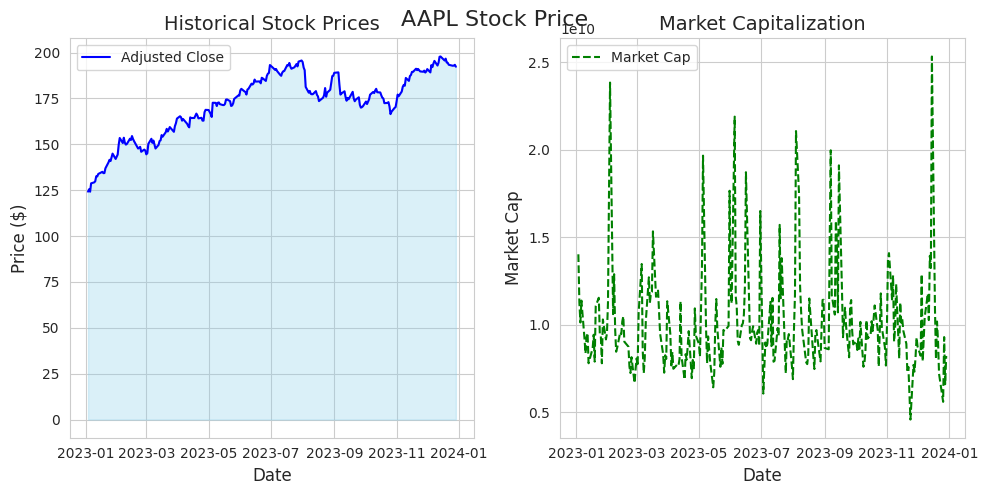

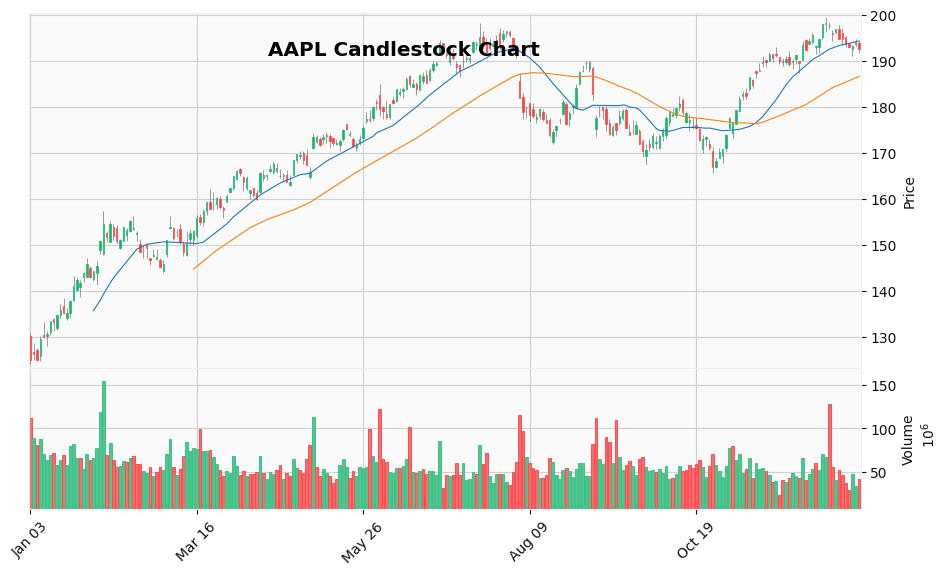

In [ ]:
obj.visualize_historical_data('AAPL', '2023-01-01', '2024-01-01', title='AAPL Stock Price', ylabel='Price ($)')

# **Fetching Historical Data from NSE API**

In [ ]:
nse_df = obj.get_historical_data_from_NSE('SBIN', 'EQ', dt.date(2024,1,1), dt.date(2024,4,4))
nse_df.head()

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,04-Apr-2024,EQ,775.00,775.30,758.10,771.05,760.80,759.30,763.24,793.4,519.05,15889530,1.212748e+10,263762
1,03-Apr-2024,EQ,764.90,772.60,760.15,766.40,771.00,771.05,767.84,793.4,519.05,19136981,1.469420e+10,277412
2,02-Apr-2024,EQ,758.20,768.75,753.35,758.30,765.95,766.40,761.63,793.4,519.05,15713063,1.196752e+10,199522
3,01-Apr-2024,EQ,759.05,761.50,752.10,752.35,758.00,758.30,757.16,793.4,519.05,9949971,7.533679e+09,155072
4,28-Mar-2024,EQ,737.75,759.55,736.90,733.30,752.95,752.35,750.83,793.4,501.55,21705116,1.629676e+10,250615


# **Download Fetched Stock Data as Desired File Format**

In [ ]:
obj.download_dataframe_as_file(df, 'pdf', 'MSFT_hist_data')

In [ ]:
obj.download_dataframe_as_file(df, 'html', 'MSFT_hist_data')

In [ ]:
obj.download_dataframe_as_file(df, 'jason', 'MSFT_hist_data')

Error downloading DataFrame as file: Invalid file format. Please use 'pdf', 'csv', 'excel', 'json', 'html', or 'feather'.


# **Moving Average**

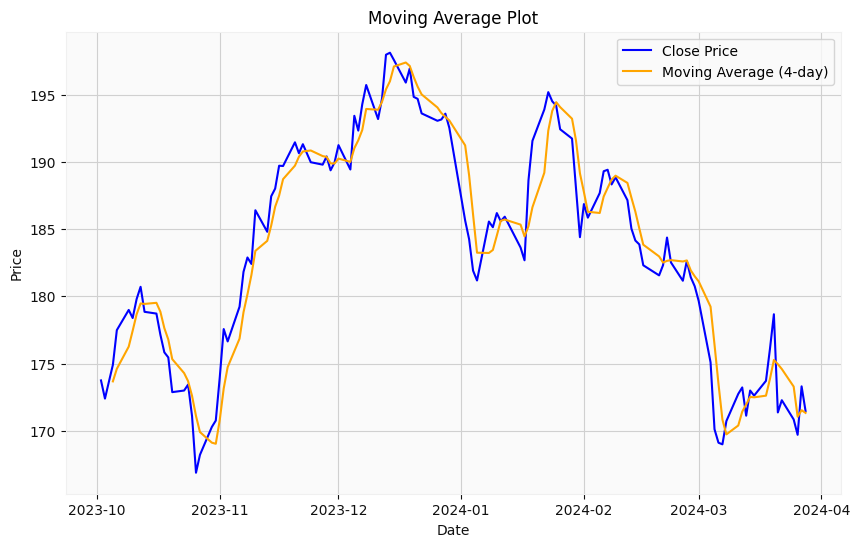

Date
2023-10-02           NaN
2023-10-03           NaN
2023-10-04           NaN
2023-10-05    173.680000
2023-10-06    174.615002
Name: Close, dtype: float64

In [ ]:
df_mva = obj.calculate_moving_average(df, period=4)

df_mva.head()

# **MACD**

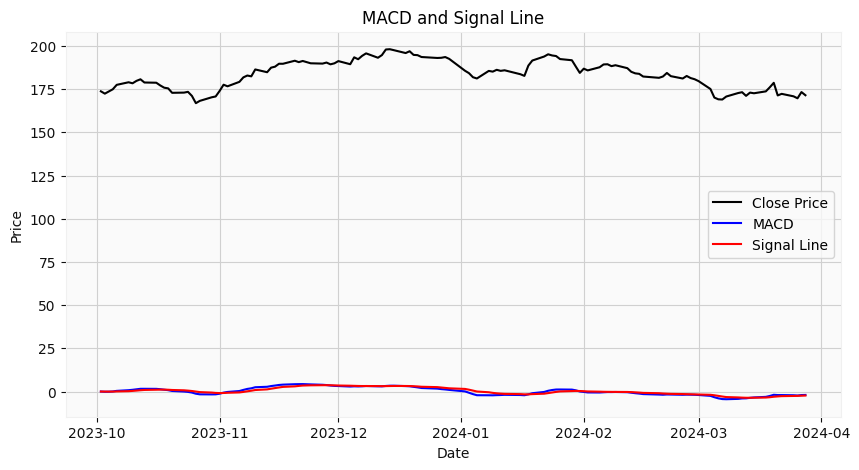

,Open,High,Low,Close,Adj Close,Volume,10_ema,22_ema,MACD,Signal_Line
Date,,,,,,,,,,
2023-10-02,171.220001,174.300003,170.929993,173.750000,173.300262,52164500,173.750000,173.750000,0.000000,0.000000
2023-10-03,172.259995,173.630005,170.820007,172.399994,171.953751,49594600,173.504544,173.632608,-0.128064,-0.025613
2023-10-04,171.089996,174.210007,170.970001,173.660004,173.210495,53020300,173.532810,173.634990,-0.102181,-0.040926
2023-10-05,173.789993,175.449997,172.679993,174.910004,174.457260,48527900,173.783209,173.745861,0.037347,-0.025272
2023-10-06,173.800003,177.990005,173.179993,177.490005,177.030594,57224100,174.457172,174.071439,0.385733,0.056929


In [ ]:
df_macd = obj.calculate_moving_average_convergence_divergence(df, short_window=10, long_window=22)

df_macd.head()

In [ ]:
df_macd.head()

,Open,High,Low,Close,Adj Close,Volume,10_ema,22_ema,MACD,Signal_Line
Date,,,,,,,,,,
2023-10-02,171.220001,174.300003,170.929993,173.750000,173.300262,52164500,173.750000,173.750000,0.000000,0.000000
2023-10-03,172.259995,173.630005,170.820007,172.399994,171.953751,49594600,173.504544,173.632608,-0.128064,-0.025613
2023-10-04,171.089996,174.210007,170.970001,173.660004,173.210495,53020300,173.532810,173.634990,-0.102181,-0.040926
2023-10-05,173.789993,175.449997,172.679993,174.910004,174.457260,48527900,173.783209,173.745861,0.037347,-0.025272
2023-10-06,173.800003,177.990005,173.179993,177.490005,177.030594,57224100,174.457172,174.071439,0.385733,0.056929


# **Valuation Ratio**

In [ ]:
obj.calculate_valuation_ratios(ticker='AAPL')

{'P/E Ratio': 28.375776,
 'P/B Ratio': 0.02651864035087719,
 'PEG Ratio': 40.53682285714285}

# **Volatility**

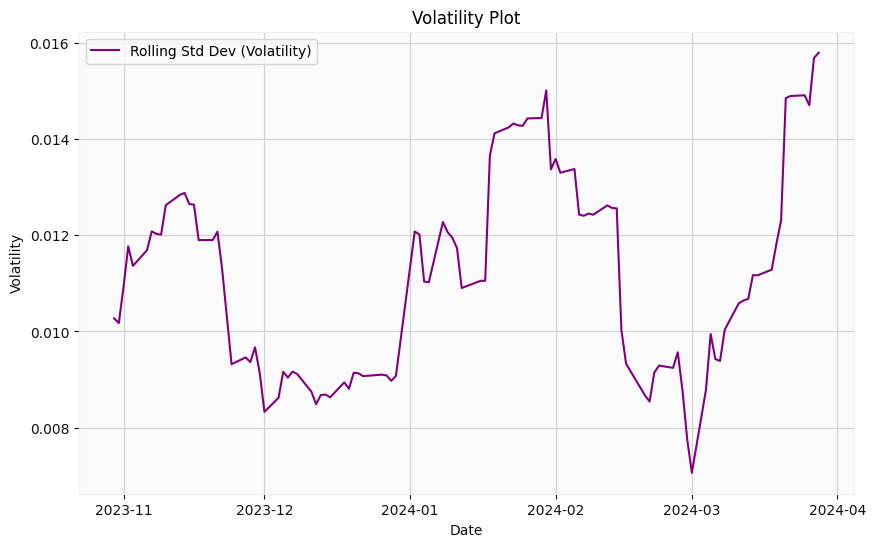

Date
2023-10-02   NaN
2023-10-03   NaN
2023-10-04   NaN
2023-10-05   NaN
2023-10-06   NaN
Name: Close, dtype: float64

In [ ]:
df_vlt = obj.calculate_volatility(df)

df_vlt.head()

In [ ]:
# event_date = "2023-04-25"  # Example event date (can be changed)
# df_event = obj.event_analysis("AAPL", event_date)
# print(df_event.head())


# **Value at Risk**

<ipython-input-5-b38fd82332a4>:524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['returns'] = df.Close.pct_change()


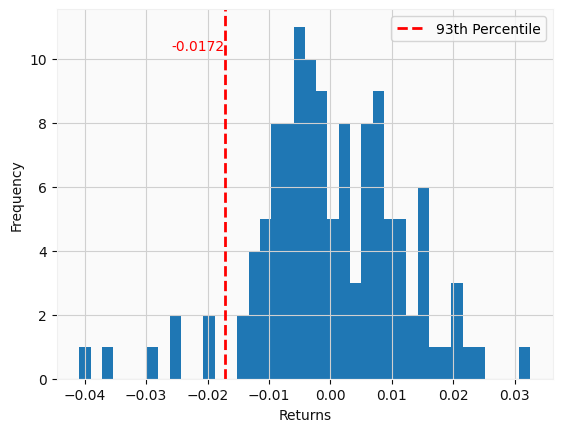

Value at Risk: -0.017219999816942347


In [ ]:
var = obj.calculate_value_at_risk(df, confidence_level=0.93)

print('Value at Risk:', var)

# **Relative Strength Index**

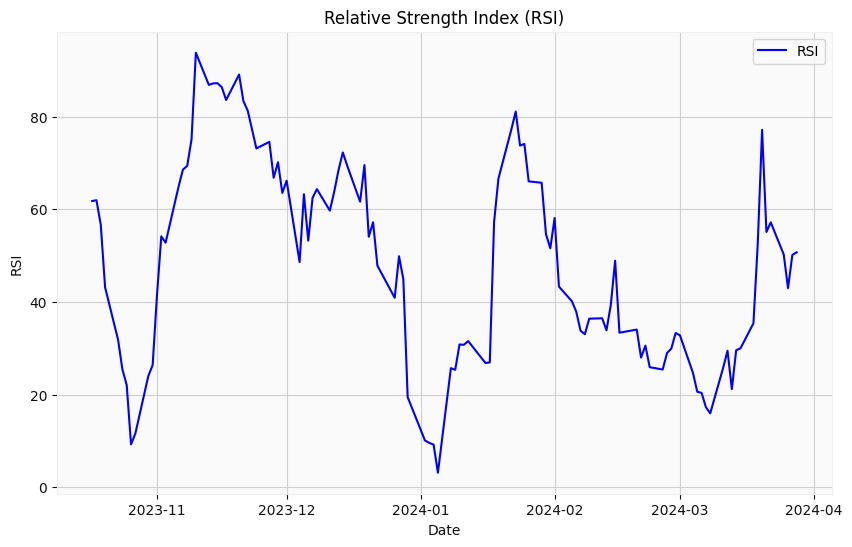

In [ ]:
rsi = obj.calculate_relative_strength_index(df, period=11)

In [ ]:
rsi.tail()

Date
2024-03-22    57.180384
2024-03-25    50.266217
2024-03-26    42.982468
2024-03-27    50.161424
2024-03-28    50.713976
Name: Returns, dtype: float64